# Defog Quick Start Demo (15 minutes)

Welcome to the defog-python library! This notebook demonstrates the core capabilities:
- Chat with multiple LLM providers using a unified interface
- Extract structured data from PDFs and images
- Query databases with natural language
- Use agents for complex reasoning tasks

**Time:** ~15 minutes | **Level:** Beginner | **Prerequisites:** API keys for at least one provider

## 1. Setup and Installation

First, let's install defog-python and set up our environment.

In [6]:
# Install defog-python (uncomment if not already installed)
# !pip install defog-python[all]

# Import required libraries
import os
import asyncio
import pandas as pd
from typing import List
from pydantic import BaseModel, Field
from IPython.display import display, Markdown, HTML, Image
import warnings
warnings.filterwarnings('ignore')

# Import defog components
from defog.llm.utils import chat_async
from defog.llm.pdf_data_extractor import PDFDataExtractor
from defog.llm.image_data_extractor import ImageDataExtractor
from defog.llm.sql import sql_answer_tool
from defog.llm.thinking_agent import ThinkingAgent
from defog.llm.orchestrator import Orchestrator
import duckdb

## 2. Configure API Keys

Set up your API keys. You only need one provider to get started!

In [7]:
# Option 1: Set environment variables (recommended)
# os.environ["OPENAI_API_KEY"] = "your-openai-key"
# os.environ["ANTHROPIC_API_KEY"] = "your-anthropic-key"
# os.environ["GEMINI_API_KEY"] = "your-gemini-key"

# Option 2: Load from .env file
# from dotenv import load_dotenv
# load_dotenv()

# Check which providers are available
available_providers = []
for provider in ["OPENAI", "ANTHROPIC", "GEMINI"]:
    if os.getenv(f"{provider}_API_KEY"):
        available_providers.append(provider.lower())

print(f"Available providers: {available_providers}")
if not available_providers:
    print("⚠️  No API keys found! Please set at least one provider's API key above.")
else:
    default_provider = available_providers[0]
    default_api_key = os.getenv(f"{default_provider.upper()}_API_KEY")

Available providers: ['openai', 'anthropic', 'gemini']


## 3. Simple Chat - Unified LLM Interface

The `chat_async` function provides a unified interface for all LLM providers.

In [10]:
# Simple chat example
messages = [
    {"role": "user", "content": "What are the main benefits of using LLMs for data analysis?"}
]

response = await chat_async(
    messages=messages,
    provider="openai",
    model="gpt-4.1",
    temperature=0.7
)

display(Markdown(f"**Response:** {response.content}"))

**Response:** Using Large Language Models (LLMs) for data analysis offers several significant benefits:

**1. Natural Language Querying:**  
LLMs allow users to interact with data using natural language, eliminating the need for complex query languages (like SQL) or coding skills. This democratizes data access and enables non-technical users to perform analyses.

**2. Automated Data Exploration:**  
LLMs can quickly summarize datasets, suggest relevant analyses, identify trends, and highlight outliers or anomalies, accelerating the exploratory data analysis (EDA) phase.

**3. Code Generation and Assistance:**  
LLMs can generate code snippets (in Python, R, SQL, etc.) for data cleaning, transformation, visualization, and modeling, saving time and reducing errors for both beginners and experts.

**4. Enhanced Data Interpretation:**  
They can explain results, provide plain-language summaries, and help interpret statistical findings, making insights more accessible and actionable.

**5. Faster Insights and Prototyping:**  
By automating repetitive tasks (like report generation or dashboard creation), LLMs speed up the analysis process, allowing analysts to focus on higher-level strategic questions.

**6. Data Integration and Documentation:**  
LLMs assist in merging data from multiple sources, generating documentation, and maintaining data dictionaries, improving data governance and collaboration.

**7. Reducing Human Error:**  
Automated code and analysis generation reduces the risk of manual errors in calculations or logic.

**8. Customizable and Context-Aware:**  
LLMs can tailor analyses to specific contexts or business needs, understanding nuanced queries given enough contextual information.

**9. Scalability:**  
They can handle a broad range of tasks, from basic summaries to advanced analytics, making them versatile tools across different data analysis scenarios.

**10. Continuous Learning:**  
With fine-tuning and prompt engineering, LLMs can continually improve, adapting to new data types, domains, and user preferences.

---

**In summary:**  
LLMs streamline and democratize the data analysis process by enabling natural language interactions, automating repetitive tasks, and making insights more accessible, regardless of users’ technical expertise.

## 4. Structured Output with Pydantic

Get structured, validated responses using Pydantic models.

In [12]:
# Define a structured output format
class CricketInsight(BaseModel):
    topic: str = Field(description="Aspect of cricket being analyzed")
    insight: str = Field(description="Key insight or finding")
    relevance: str = Field(description="Why this matters")

class CricketAnalysis(BaseModel):
    insights: List[CricketInsight] = Field(description="List of cricket insights")

# Get structured response
messages = [
    {"role": "user", "content": "What are 3 key factors that contribute to winning matches in limited overs cricket?"}
]

analysis = await chat_async(
    messages=messages,
    provider="gemini",
    model="gemini-2.5-flash",
    response_format=CricketAnalysis,
    temperature=0.7
)

# Display as a nice table
df = pd.DataFrame([insight.model_dump() for insight in analysis.content.insights])
display(HTML(df.to_html(index=False)))

topic,insight,relevance
Batting Performance,"A strong batting lineup with a mix of stable accumulators and explosive hitters, capable of building partnerships and accelerating in death overs, is crucial for setting high totals or chasing challenging targets.","In limited overs, scoring rates are paramount. Top-order stability prevents collapses, while power-hitting ensures momentum and maximizes runs in the final overs, often dictating the game's outcome."
Bowling Strategy & Execution,"A diverse bowling attack, combining wicket-taking options (pace, spin, variations) with excellent death bowling execution (yorkers, slower balls, tight lines), is essential to restrict opposition scoring and pick up wickets at key moments.","Wickets restrict scoring, and effective death bowling prevents opposition batsmen from accelerating in the crucial final overs, which can significantly swing the momentum and result of a match."
Fielding & Catching,"Exceptional fielding, encompassing sharp ground fielding, athletic boundary saves, and consistent catching, is vital for saving runs and converting opportunities into wickets.","Dropped catches and misfields directly translate to extra runs for the opposition and missed chances to dismiss batsmen, which can dramatically alter the required run rate and the overall flow of the game."


## 5. Natural Language Database Queries - Cricket World Cup 2015

Query the Cricket World Cup database using natural language!

In [13]:
# Connect to the cricket database
db_conn = duckdb.connect("../sample_data/cricket_wc2015.duckdb")

# See what tables we have
tables = db_conn.execute("SHOW TABLES").fetchall()
print(f"Available tables: {[t[0] for t in tables]}")

Available tables: ['ball_by_ball', 'match_summary', 'player_batting_stats', 'player_bowling_stats', 'team_performance']


In [17]:
# Query 1: Top run scorers
result = await sql_answer_tool(
    question="Who were the top 5 run scorers in the tournament?",
    db_type="duckdb",
    db_creds={"database": "/Users/rishabh/defog/defog-python/sample_data/cricket_wc2015.duckdb"},
    provider="anthropic",
    model="claude-sonnet-4-20250514"
)

if result["success"]:
    print(f"Generated SQL: {result['query']}\n")
    df = pd.DataFrame(result["results"], columns=result["columns"])
    display(df)
else:
    print(f"Error: {result['error']}")

─────────────────────────────────────────────── 🔧 SQL Query Answer ───────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Answering: Who were the top 5 run scorers in the tournament?                                                   │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Provider: anthropic | Model: claude-sonnet-4-20250514

⚡ Extracting table metadata

Getting schema for each table that you selected...

⚡ Converting question to SQL

⚡ Running query on database

Completed in 6.8s

Generated SQL: SELECT batsman_name, runs_scored
FROM player_batting_stats
ORDER BY runs_scored DESC
LIMIT 5;



,batsman_name,runs_scored
0,Martin Guptill,547.0
1,Kumar Sangakkara,541.0
2,AB de Villiers,482.0
3,Brendan Taylor,433.0
4,Shikhar Dhawan,412.0


## 6. PDF Data Extraction - Apple Financials

Extract structured data from PDF documents.

In [25]:
# Initialize PDF extractor
pdf_extractor = PDFDataExtractor(
    analysis_model="claude-opus-4-20250514",
    extraction_model="claude-opus-4-20250514",
    max_parallel_extractions=10,
)

# Extract data
display(Markdown("### Extracting data from Amazon's financial report..."))

financial_data = await pdf_extractor.extract_all_data(
    pdf_url="https://s2.q4cdn.com/299287126/files/doc_financials/2025/q1/AMZN-Q1-2025-Earnings-Release.pdf",
)

print(financial_data)

### Extracting data from Amazon's financial report...

pdf_url='https://s2.q4cdn.com/299287126/files/doc_financials/2025/q1/AMZN-Q1-2025-Earnings-Release.pdf' document_type='unknown' total_datapoints_identified=0 successful_extractions=0 failed_extractions=0 extraction_results=[] total_time_ms=9438 total_cost_cents=3.2685 metadata={'filtered_datapoints': 0, 'schemas_generated': 0, 'total_input_tokens': 1174, 'total_output_tokens': 201, 'total_cached_tokens': 0, 'analysis_cost_cents': 3.2685, 'extraction_cost_cents': 0.0}


## 7. Image Data Extraction - Carbon Budget Visualization

Extract data from charts and visualizations in images.

### Carbon Budget Visualization

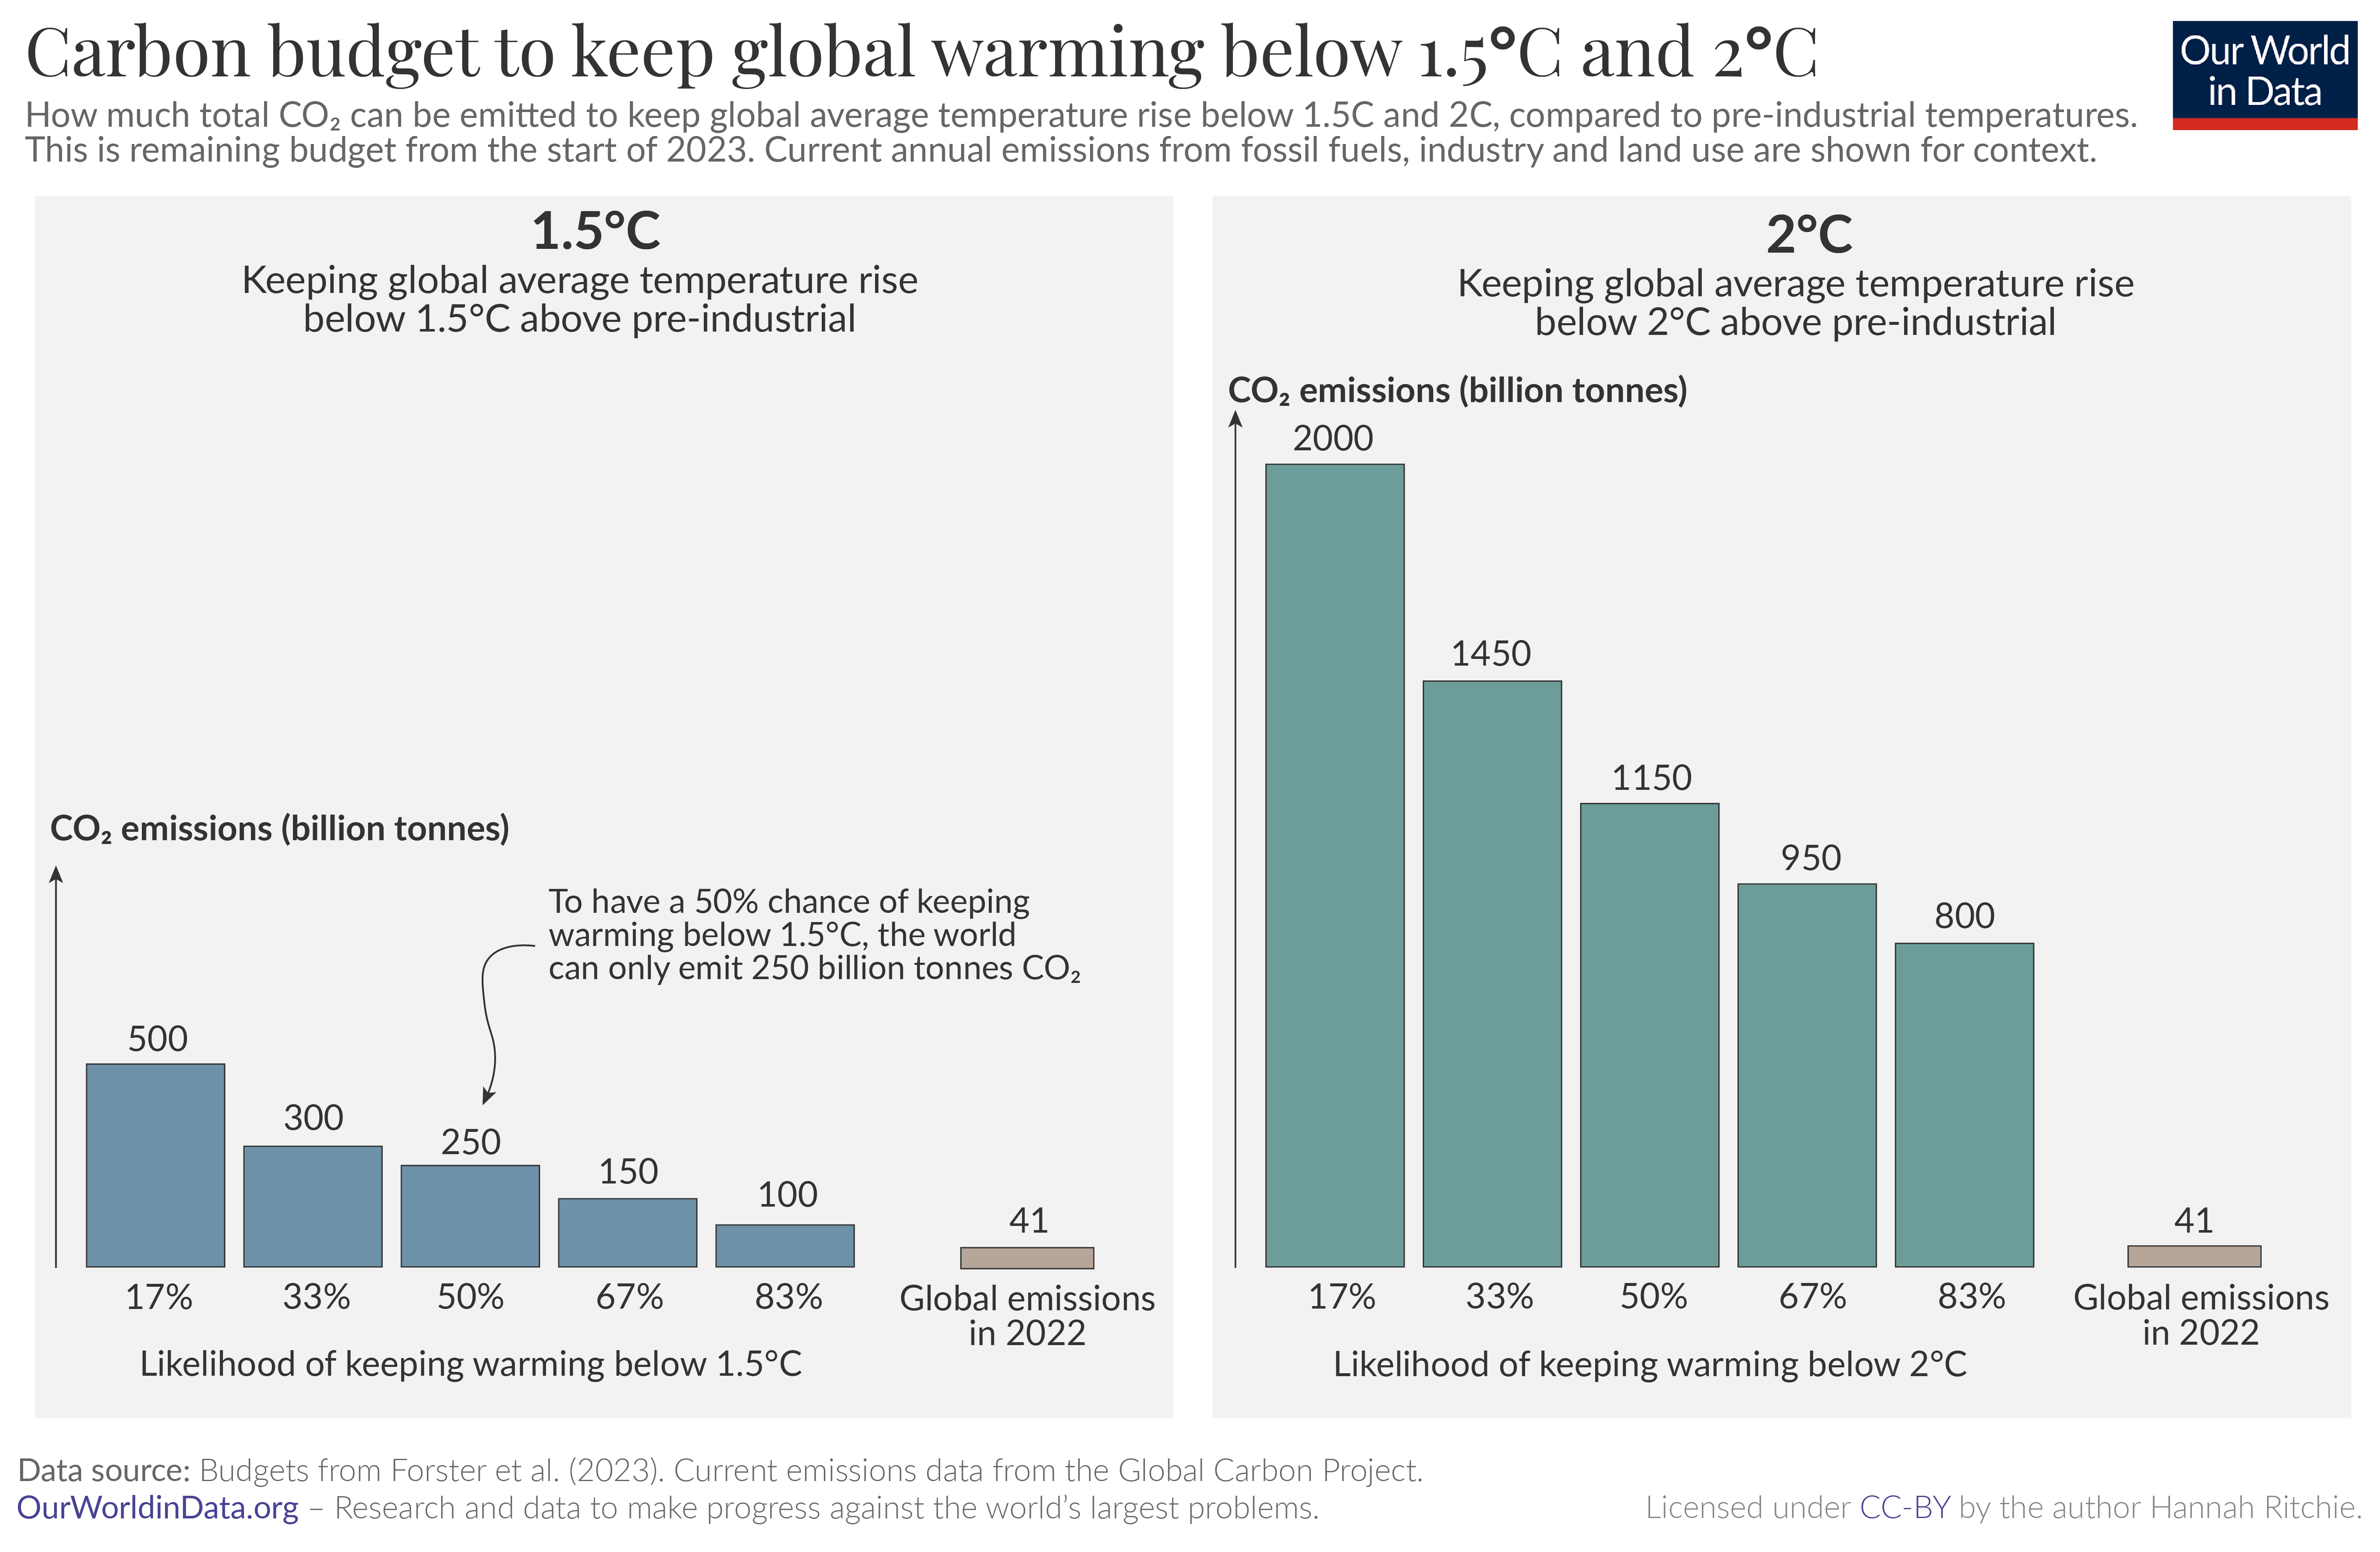

In [26]:
# Display the image
display(Markdown("### Carbon Budget Visualization"))
display(Image("../sample_data/carbon-budget.png", width=600))

In [27]:
# Initialize image extractor
image_extractor = ImageDataExtractor()

# Extract data from image
carbon_data = await image_extractor.extract_all_data(
    image_url="https://ourworldindata.org/cdn-cgi/imagedelivery/qLq-8BTgXU8yG0N6HnOy8g/1cea1569-d611-4d7f-7a9c-d01f81fab400/w=5671",
)

# Display extracted data
print(carbon_data)

image_url='https://ourworldindata.org/cdn-cgi/imagedelivery/qLq-8BTgXU8yG0N6HnOy8g/1cea1569-d611-4d7f-7a9c-d01f81fab400/w=5671' image_type='chart' total_datapoints_identified=2 successful_extractions=2 failed_extractions=0 extraction_results=[DataExtractionResult(datapoint_name='carbon_budget_1_5_degrees', success=True, extracted_data=carbon_budget_1_5_degrees(columns=['likelihood_percent', 'co2_emissions_billion_tonnes'], data=[[17, 500], [33, 300], [50, 250], [67, 150], [83, 100]], chart_type='bar_chart', row_count=5), error=None, cost_cents=0.8484, input_tokens=2413, output_tokens=83, cached_tokens=0), DataExtractionResult(datapoint_name='carbon_budget_2_degrees', success=True, extracted_data=carbon_budget_2_degrees(columns=['likelihood_percent', 'co2_emissions_billion_tonnes'], data=[[17, 2000], [33, 1450], [50, 1150], [67, 950], [83, 800]], chart_type='bar_chart', row_count=5), error=None, cost_cents=0.8504999999999998, input_tokens=2405, output_tokens=86, cached_tokens=0)] total_

## Summary & Next Steps

Congratulations! You've explored the core capabilities of defog-python:

✅ **Unified LLM Interface** - Switch between providers with one line  
✅ **Structured Output** - Get validated data with Pydantic models  
✅ **Natural Language SQL** - Query databases conversationally  
✅ **PDF Extraction** - Extract structured data from documents  
✅ **Image Analysis** - Extract data from charts and visualizations  
✅ **Thinking Agent** - Complex reasoning with transparent process  
✅ **Orchestrator** - Multi-agent collaboration for complex tasks  

### What's Next?

1. **Deep Dive Tutorial** (Notebook 2) - Advanced features:
   - Memory management for long conversations
   - Custom tools and function calling
   - Advanced extraction with HTML and text
   - Building production pipelines

2. **Production Patterns** (Notebook 3) - Best practices:
   - Error handling and retries
   - Cost optimization
   - Performance tuning
   - Security considerations

### Try These Challenges:

- Extract data from your own PDFs or images
- Create custom Pydantic schemas for your use case
- Build a data pipeline combining multiple sources
- Compare provider performance on your specific tasks

### Resources:

- Documentation: [defog.ai/docs](https://defog.ai/docs)
- GitHub: [github.com/defog-ai/defog-python](https://github.com/defog-ai/defog-python)
- Support: support@defog.ai

Happy building! 🚀